In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Specify the path to your Excel file
excel_file_path = 'CustomQuery.xlsx'

In [4]:
# Read the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Display the first few rows of the DataFrame
print(df.head(20))

                       Economy    Year  Subgroup Top Subgroup Level  \
0                          All     NaN       NaN                NaN   
1          East Asia & Pacific     NaN       NaN                NaN   
2        Europe & Central Asia     NaN       NaN                NaN   
3    Latin America & Caribbean     NaN       NaN                NaN   
4   Middle East & North Africa     NaN       NaN                NaN   
5                   South Asia     NaN       NaN                NaN   
6           Sub-Saharan Africa     NaN       NaN                NaN   
7                  Afghanistan  2008.0       NaN                NaN   
8                  Afghanistan  2008.0    Sector      Manufacturing   
9                  Afghanistan  2008.0    Sector      Manufacturing   
10                 Afghanistan  2008.0    Sector           Services   
11                 Afghanistan  2008.0    Sector           Services   
12                 Afghanistan  2008.0    Sector           Services   
13    

In [14]:
df.columns = df.columns.str.strip()  # Remove any leading/trailing whitespace
print("Column Names:")
print(df.columns.tolist())

Column Names:
['Economy', 'Year', 'Subgroup', 'Top Subgroup Level', 'Subgroup Level', 'Average/SE/N', 'Percent of firms experiencing electrical outages', '[B-READY] Number of electrical outages in a typical month', '[B-READY] Duration, in hours, of a typical electrical outage [median]', '[B-READY] Losses due to electrical outages (% of annual sales) [median]', '[B-READY] Percent of firms owning or sharing  a generator', '[B-READY] Days to obtain an electrical connection, upon application [median]', 'Percent of firms identifying electricity as a major or very severe constraint', '[B-READY] Percent of firms experiencing water insufficiencies', 'Number of water insufficiencies in a typical month', 'Duration, in hours, of a typical water shortage', '[B-READY] Days to obtain a water connection [median]', '[B-READY] Percent of firms experiencing internet disruptions', '[B-READY] Days to obtain internet connection [median]', 'Percent of firms identifying transportation as a major or very seve

In [7]:
df_numeric = df.apply(pd.to_numeric, errors='coerce')  # Convert possible numeric columns to numbers
summary_numeric = df_numeric.describe()
print(summary_numeric)

       Economy         Year  Subgroup  Top Subgroup Level  Subgroup Level  \
count      0.0  7384.000000       0.0                 0.0             0.0   
mean       NaN  2014.313109       NaN                 NaN             NaN   
std        NaN     5.442446       NaN                 NaN             NaN   
min        NaN  2006.000000       NaN                 NaN             NaN   
25%        NaN  2009.000000       NaN                 NaN             NaN   
50%        NaN  2013.000000       NaN                 NaN             NaN   
75%        NaN  2019.000000       NaN                 NaN             NaN   
max        NaN  2023.000000       NaN                 NaN             NaN   

       Average/SE/N  Percent of firms experiencing electrical outages  \
count           0.0                                       7318.000000   
mean            NaN                                         52.580049   
std             NaN                                         27.744276   
min           

In [9]:
summary_categorical = df.describe(include=['object'])
print(summary_categorical)

                   Economy Subgroup Top Subgroup Level Subgroup Level  \
count                 7391     7027               2377           7027   
unique                 166        6                  2           1055   
top     Russian Federation   Sector      Manufacturing            All   
freq                   118     2377               1260            714   

       Average/SE/N Percent of firms experiencing electrical outages  \
count          7391                                             7369   
unique            1                                              995   
top         Average                                              100   
freq           7391                                              120   

       [B-READY] Number of electrical outages in a typical month  \
count                                                7369          
unique                                                513          
top                                                   0.2          
f

In [10]:
# List of potential numeric columns to convert
columns_to_convert = ['Percent of firms experiencing electrical outages', 
                      '[B-READY] Number of electrical outages in a typical month', 
                      '[B-READY] Duration, in hours, of a typical electrical outage [median]']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Get descriptive statistics after conversion
print(df.describe())

              Year  Percent of firms experiencing electrical outages  \
count  7384.000000                                       7318.000000   
mean   2014.313109                                         52.580049   
std       5.442446                                         27.744276   
min    2006.000000                                          0.000000   
25%    2009.000000                                         29.400000   
50%    2013.000000                                         50.200000   
75%    2019.000000                                         77.900000   
max    2023.000000                                        100.000000   

       [B-READY] Number of electrical outages in a typical month  \
count                                        7306.000000           
mean                                            5.499849           
std                                            12.762835           
min                                             0.000000           
25%        

In [15]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Economy                                                                                          0
Year                                                                                             7
Subgroup                                                                                       364
Top Subgroup Level                                                                            5014
Subgroup Level                                                                                 364
Average/SE/N                                                                                     0
Percent of firms experiencing electrical outages                                                73
[B-READY] Number of electrical outages in a typical month                                       85
[B-READY] Duration, in hours, of a typical electrical outage [median]                           79
[B-READY] Losses due to electrical outages (% of annual sales) [median]                     

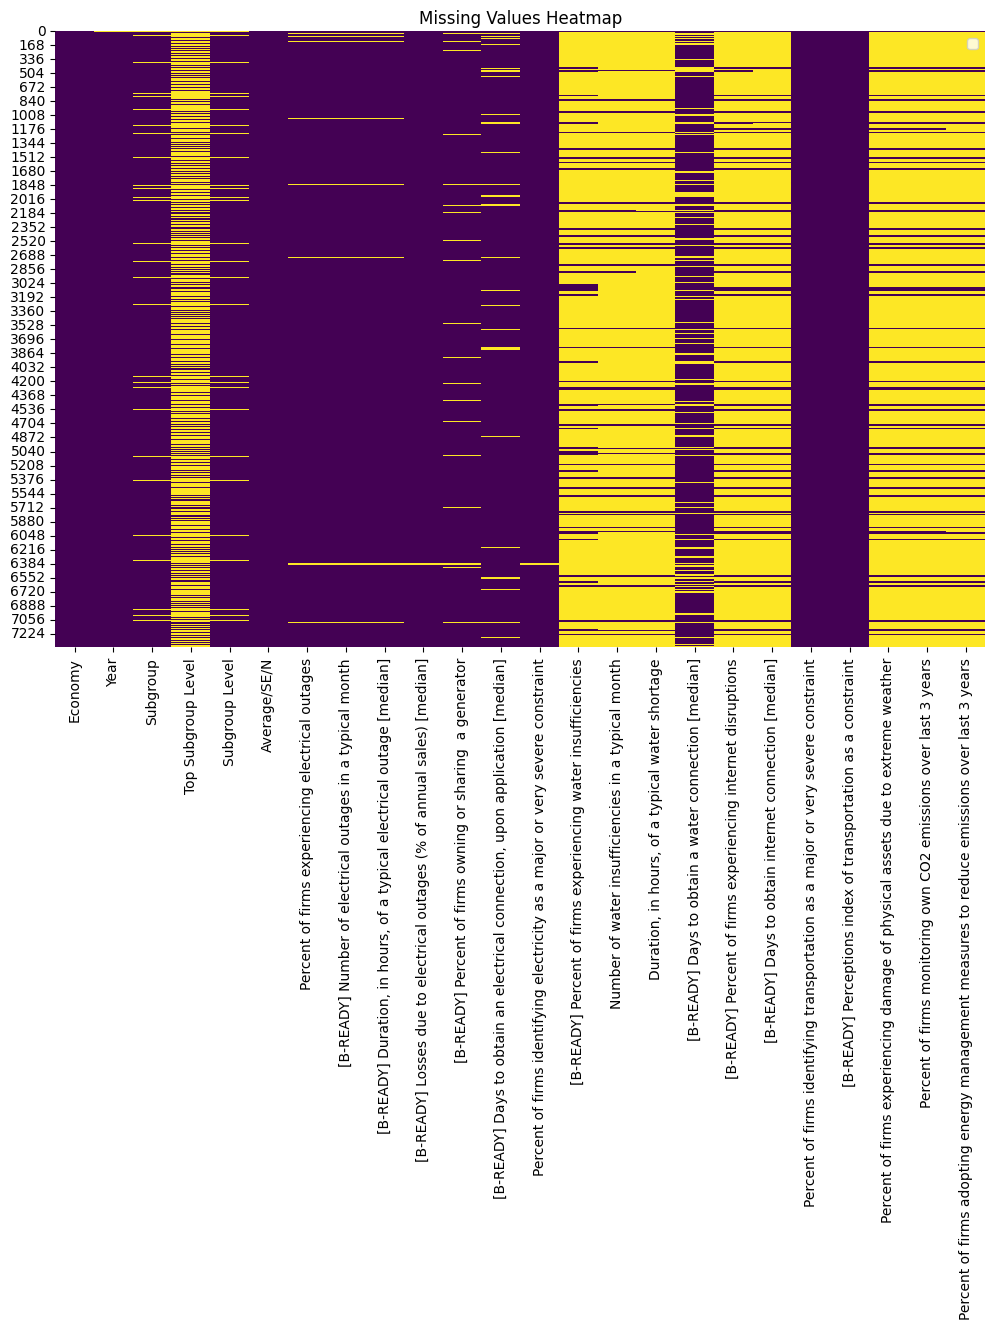

In [18]:
# Visualize missing data
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.legend(['Yellow: Missing Values', 'Purple: Present Values'], loc='upper right')
plt.show()

In [19]:
# Step 3: Decide on a Target Column
# Display column names and ask user to decide on a target
# For this example, let's proceed with "Percent of firms monitoring own CO2 emissions over last 3 years"
target_column = 'Percent of firms monitoring own CO2 emissions over last 3 years'

In [20]:
# Define features and target
features = df.drop(columns=[target_column])
target = df[target_column]

In [21]:
# Step 4: Data Cleaning and Preprocessing
# Replace non-numeric values ('n.a.') with NaN in both features and target
features.replace('n.a.', np.nan, inplace=True)
target.replace('n.a.', np.nan, inplace=True)

In [22]:
# Impute missing values for numerical features and target
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = features.select_dtypes(include=['object']).columns

In [23]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [24]:
# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [25]:
# Impute missing values in the target
target_imputer = SimpleImputer(strategy='mean')
target_imputed = target_imputer.fit_transform(target.values.reshape(-1, 1)).ravel()


In [26]:
# Step 5: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(features, target_imputed, test_size=0.2, random_state=42)

In [27]:
# Step 6: Create and Evaluate Models
# Create a pipeline that includes the preprocessor and model
# Model 1: Linear Regression
linear_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', LinearRegression())])


In [28]:
# Fit the model
linear_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year', 'Percent of firms experiencing electrical outages',
       '[B-READY] Number of electrical outages in a typical month',
       '[B-READY] Duration, in hours, of a typical electrical outage [median]'],
      dtype='object')),
                                                 ('cat',
                                                  Pipel...
       '[B-READY] Days to obtain internet connection [median]',
       'Percent of firms identifying transportation as a major or very severe constraint',
       '[B-READY] Perceptions index of transportation as a constraint',
       'Percent of firms experiencing damage of physical assets due to extreme weather',
       'Percent of firms adopting energy management measures to reduce emissions over last 3 years'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [46]:
# Predict and evaluate
y_pred_linear = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)
linear_mae = mean_absolute_error(y_test, y_pred_linear)
print(f"\nLinear Regression - MSE: {linear_mse}, R2: {linear_r2}, MAE: {linear_mae}")



Linear Regression - MSE: 21.267655843210655, R2: -0.061398992988504375, MAE: 1.4187281099965834


In [30]:
# Model 2: Decision Tree Regressor
tree_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', DecisionTreeRegressor(random_state=42))])

In [31]:
# Fit the model
tree_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year', 'Percent of firms experiencing electrical outages',
       '[B-READY] Number of electrical outages in a typical month',
       '[B-READY] Duration, in hours, of a typical electrical outage [median]'],
      dtype='object')),
                                                 ('cat',
                                                  Pipel...
       'Percent of firms identifying transportation as a major or very severe constraint',
       '[B-READY] Perceptions index of transportation as a constraint',
       'Percent of firms experiencing damage of physical assets due to extreme weather',
       'Percent of firms adopting energy management measures to reduce emissions over last 3 years'],
      dtype='object'))])),
                ('model', DecisionTreeRegressor(random_state=42))])

In [47]:
# Predict and evaluate
y_pred_tree = tree_model.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred_tree)
tree_r2 = r2_score(y_test, y_pred_tree)
tree_mae = mean_absolute_error(y_test, y_pred_tree)
print(f"\nDecision Tree Regressor - MSE: {tree_mse}, R2: {tree_r2}, MAE: {tree_mae}")


Decision Tree Regressor - MSE: 13.359768387837278, R2: 0.33325774979865097, MAE: 0.7799309729581408


In [33]:
# Model 3: Random Forest Regressor
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(random_state=42))])


In [34]:
# Fit the model
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year', 'Percent of firms experiencing electrical outages',
       '[B-READY] Number of electrical outages in a typical month',
       '[B-READY] Duration, in hours, of a typical electrical outage [median]'],
      dtype='object')),
                                                 ('cat',
                                                  Pipel...
       'Percent of firms identifying transportation as a major or very severe constraint',
       '[B-READY] Perceptions index of transportation as a constraint',
       'Percent of firms experiencing damage of physical assets due to extreme weather',
       'Percent of firms adopting energy management measures to reduce emissions over last 3 years'],
      dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [48]:
# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print(f"\nRandom Forest Regressor - MSE: {rf_mse}, R2: {rf_r2}, MAE: {rf_mae}")


Random Forest Regressor - MSE: 9.266761813819112, R2: 0.537526292038818, MAE: 0.6802019705374536


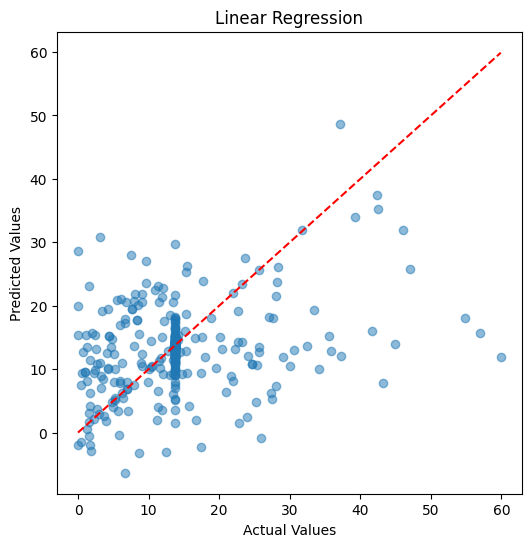

In [41]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')
plt.show()

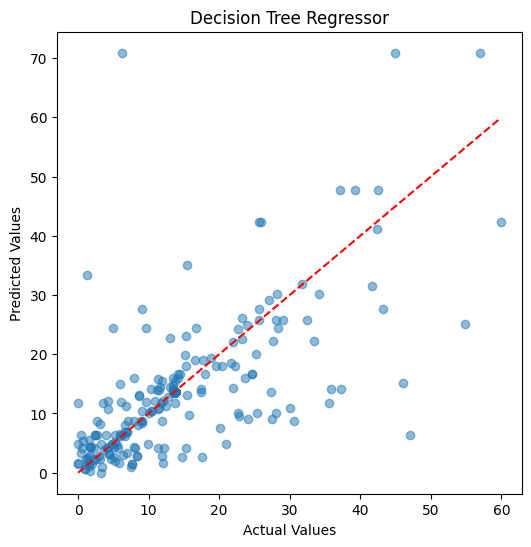

In [42]:
# Plot Decision Tree Regressor results
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_tree, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Regressor')
plt.show()

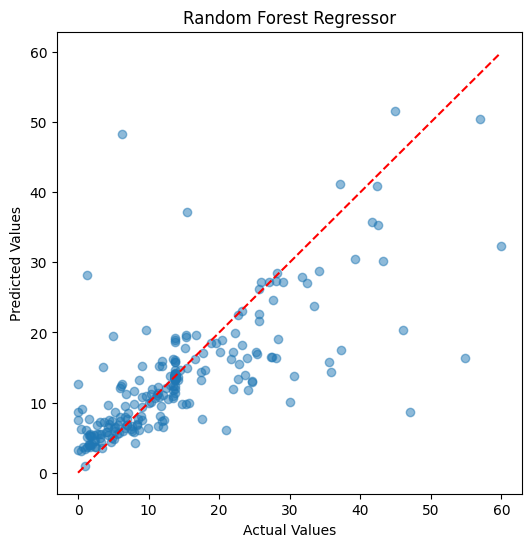

In [43]:
# Plot Random Forest Regressor results
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor')
plt.show()

In [49]:
summary_data = {
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor'],
    'MSE': [linear_mse, tree_mse, rf_mse],
    'R2 Score': [linear_r2, tree_r2, rf_r2],
    'MAE': [linear_mae, tree_mae, rf_mae]
}

In [51]:
summary_df = pd.DataFrame(summary_data)
print("Model Summary Statistics:")
print(summary_df)

Model Summary Statistics:
                     Model        MSE  R2 Score       MAE
0        Linear Regression  21.267656 -0.061399  1.418728
1  Decision Tree Regressor  13.359768  0.333258  0.779931
2  Random Forest Regressor   9.266762  0.537526  0.680202


In [54]:
linear_cv_scores = cross_val_score(linear_model, features, target_imputed, cv=5, scoring='r2')
print(f"\nLinear Regression Cross-Validation R2 Scores: {linear_cv_scores}")
print(f"Linear Regression Cross-Validation Mean R2: {linear_cv_scores.mean()}")



Linear Regression Cross-Validation R2 Scores: [-0.09589441 -0.32998605 -0.16090016 -0.60436584 -0.71561954]
Linear Regression Cross-Validation Mean R2: -0.3813532001518711


In [55]:
# Decision Tree Regressor - Cross-validation
tree_cv_scores = cross_val_score(tree_model, features, target_imputed, cv=5, scoring='r2')
print(f"\nDecision Tree Regressor Cross-Validation R2 Scores: {tree_cv_scores}")
print(f"Decision Tree Regressor Cross-Validation Mean R2: {tree_cv_scores.mean()}")


Decision Tree Regressor Cross-Validation R2 Scores: [-0.50155841 -0.52377765 -0.31098512 -0.46227759 -0.05944893]
Decision Tree Regressor Cross-Validation Mean R2: -0.3716095406415739


In [56]:
# Random Forest Regressor - Cross-validation
rf_cv_scores = cross_val_score(rf_model, features, target_imputed, cv=5, scoring='r2')
print(f"\nRandom Forest Regressor Cross-Validation R2 Scores: {rf_cv_scores}")
print(f"Random Forest Regressor Cross-Validation Mean R2: {rf_cv_scores.mean()}")


Random Forest Regressor Cross-Validation R2 Scores: [-0.04673628 -0.25941111 -0.0897948  -0.21682281  0.2757953 ]
Random Forest Regressor Cross-Validation Mean R2: -0.06739394194940258


In [57]:
robustness_data = {
    'Model': ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor'],
    'Cross-Validation Mean R2': [linear_cv_scores.mean(), tree_cv_scores.mean(), rf_cv_scores.mean()]
}

In [58]:
robustness_df = pd.DataFrame(robustness_data)
print(robustness_df)

                     Model  Cross-Validation Mean R2
0        Linear Regression                 -0.381353
1  Decision Tree Regressor                 -0.371610
2  Random Forest Regressor                 -0.067394


In [65]:
# Step 11: Bootstrapping for Model Reliability
n_iterations = 100
n_size = int(len(X_train) * 0.5)

In [66]:
bootstrap_results = []
for model, model_name in zip([linear_model, tree_model, rf_model], ['Linear Regression', 'Decision Tree Regressor', 'Random Forest Regressor']):
    scores = []
    for _ in range(n_iterations):
        # Create a bootstrap sample
        X_resampled, y_resampled = resample(X_train, y_train, n_samples=n_size, random_state=None)
        model.fit(X_resampled, y_resampled)
        y_resampled_pred = model.predict(X_test)
        score = r2_score(y_test, y_resampled_pred)
        scores.append(score)
    bootstrap_results.append({'Model': model_name, 'Bootstrap Mean R2': np.mean(scores), 'Bootstrap Std R2': np.std(scores)})


In [67]:
# Create a DataFrame to display bootstrap results
bootstrap_df = pd.DataFrame(bootstrap_results)
print("\nBootstrap Results for Model Reliability:")
print(bootstrap_df)


Bootstrap Results for Model Reliability:
                     Model  Bootstrap Mean R2  Bootstrap Std R2
0        Linear Regression          -0.057819          0.050010
1  Decision Tree Regressor           0.017263          0.176332
2  Random Forest Regressor           0.310527          0.061691
